In [3]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

import torch
from invertible_network_utils import construct_invertible_mlp


import matplotlib.pyplot as plt
from simclr.simclr import SimCLR
from spaces import NSphereSpace

from visualization_utils.spheres import visualize_spheres_side_by_side, scatter3d_sphere

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using', device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cuda


condition number threshold: 2.899491
layer 1/3,  condition number: 2.7508647517711613
layer 2/3,  condition number: 2.700385774991923
layer 3/3,  condition number: 2.204525180107384
MAX NORM: tensor(1.0087)


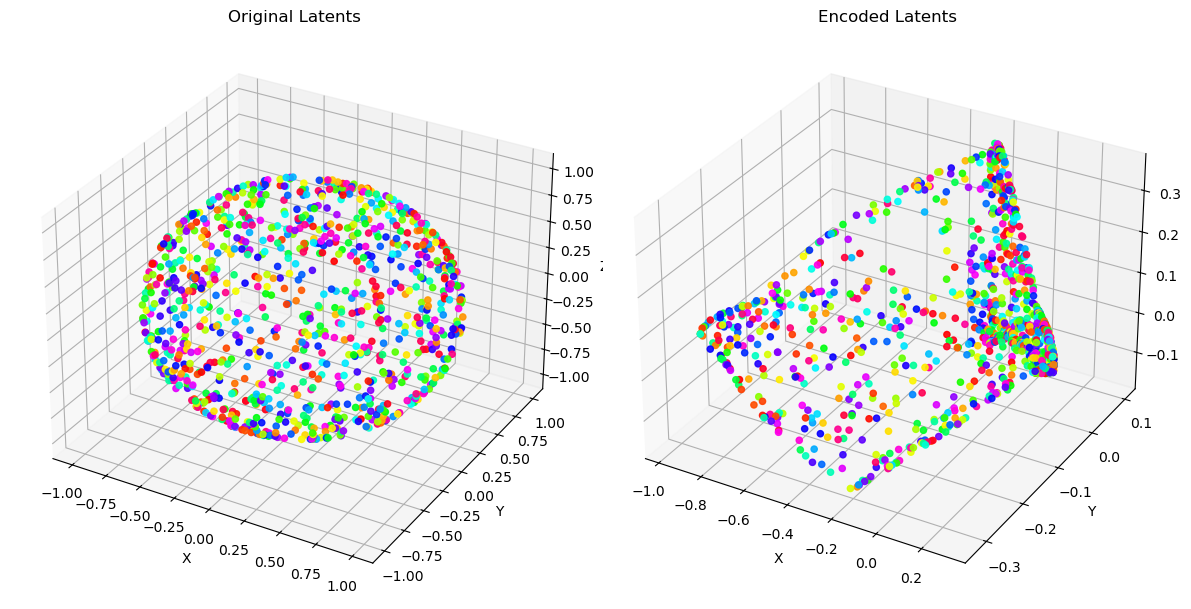

In [5]:
sphere = NSphereSpace(3)
g_mlp = construct_invertible_mlp(n=3, n_layers=3, act_fct="leaky_relu")

z = sphere.uniform(1000)

print('MAX NORM:',(g_mlp(z) ** 2).sum(dim=1).max())

visualize_spheres_side_by_side(plt, z, g_mlp(z))

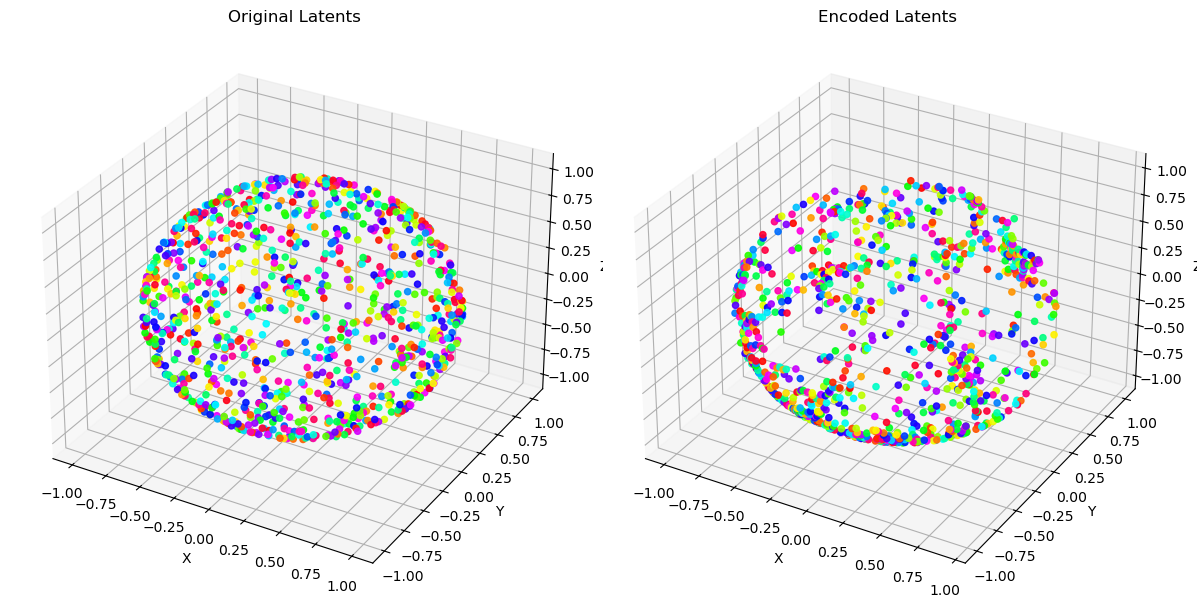

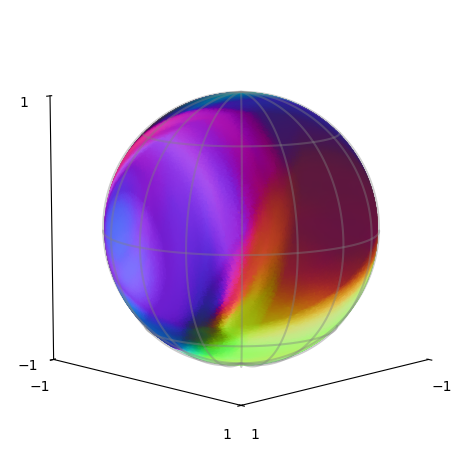

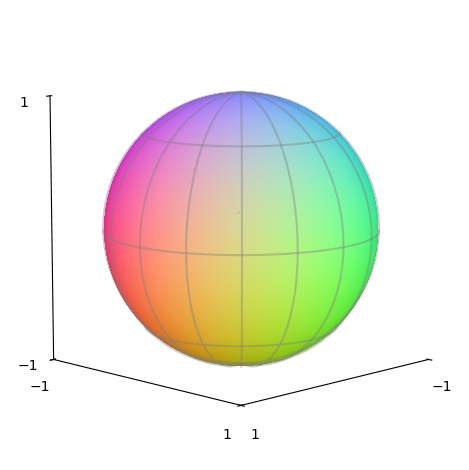

In [12]:
from encoders import SphericalEncoder

tau = 0.3
kappa = 1 / tau

iterations = 10000
batch = 6144

sample_pair_fixed = lambda batch: sphere.sample_pair_vmf(batch, kappa)
sample_uniform_fixed = lambda batch: sphere.uniform(batch)

f = SphericalEncoder()

h = lambda z: f(g_mlp(z))

z = sphere.uniform(1000)
z_enc = h(z)

# Add coloring corresponding to initial points

visualize_spheres_side_by_side(plt, z, z_enc)

z = sphere.uniform(100000)

fig = scatter3d_sphere(plt, z.cpu(), h(z.cpu()).cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

In [ ]:
from visualization_utils.scoring import plot_scores
from experiment_utils.linear import linear_unrotation

f = SphericalEncoder()

simclr_vmf = SimCLR(
    f, g_mlp, sample_pair_fixed, sample_uniform_fixed, tau, device
)

f, scores = simclr_vmf.train(batch, iterations)

h = lambda z: f(g_mlp(z))

z = sphere.uniform(1000).to(device)
z_enc = h(z).to(device)

plot_scores(plt, scores)
visualize_spheres_side_by_side(plt, z.cpu(), z_enc.cpu())

z = sphere.uniform(100000).to(device)
z_enc = h(z)

fig = scatter3d_sphere(plt, z.cpu(), z_enc.cpu(), s=10, a=.8)
fig = scatter3d_sphere(plt, z.cpu(), z.cpu(), s=10, a=.8)

# Unrotation
z_unrotated = linear_unrotation(z, z_enc)
fig = scatter3d_sphere(plt, z.cpu(), z_unrotated, s=10, a=.8)